# Случайность в вероятности и на практике

О подходах к понятию случайности: 

Н.К. Верещагин, В.А. Успенский, А. Шень. Колмогоровская сложность и алгоритмическая случайность. 
https://www.mccme.ru/free-books/shen/kolmbook.pdf

А.Н. Ширяев. Случайность в вероятности (доклад на семинаре кафедры теории веротяностей). http://www.mathnet.ru:8080/PresentFiles/21897/bsk_2018_10_17_shiryaev_an_randomness_in_probability_slides.pdf

## Генераторы случайных чисел

Что происходит при вызове, напрмер, ```np.random.rand()```?

Как устроен источник случайной последовательности?

![img](https://cdn.ablebits.com/_img-blog/random-generator/random-generator.png)

Рассмотрим простой и популрный алгоритм - Linear congruential generator (LCG). При вызове функции ```rand()``` в C/C++ происзодит обращение именно к LCG.

Linear congruential generator производит последовательность:
$$ z_{i+1} = (az_i + c) \mod m $$

Число $z_0$ называется *seed* и обеспечивает воспроизводимость последовательности “случайных” чисел.

Напишем функцию, которая реализует LCG:

In [2]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

Выведем несколько первых элементов последовательности:

In [ ]:
[rng() for i in range(10)]

Выбор параметров $m$, $a$ и $c$ существенно влияет на качество последовательности. Если параметры выбрать наобум, это может привести к неожиданным последствиям:

In [3]:
def rng(m=97, a=5, c=0):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 7

random = [rng() for i in range(1000)]
print("This sequence looks as random:")
random[:10]

This sequence looks as random:


[0.36082474226804123,
 0.8041237113402062,
 0.020618556701030927,
 0.10309278350515463,
 0.5154639175257731,
 0.5773195876288659,
 0.8865979381443299,
 0.4329896907216495,
 0.16494845360824742,
 0.8247422680412371]

Гистограмма распределения похожа на равномерное:

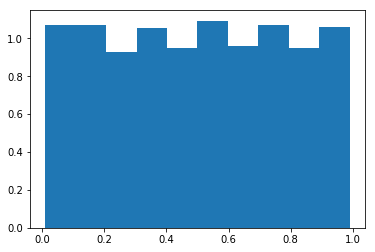

In [5]:
import matplotlib.pyplot as plt
plt.hist(random, normed=True)
plt.show()

Однако, спектральный тест показывает, что точки располагаются на гиперплоскостях, что плохо согласуется с предствалением о случайности:

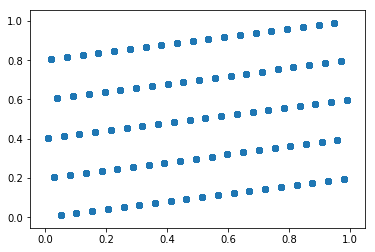

In [6]:
plt.scatter(random[1:], random[:-1])
plt.show()

Более аккуратный выбор параметров приводит с более "случайному" распределению:

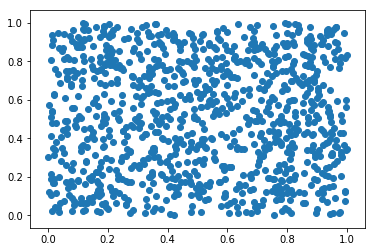

In [7]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m
rng.current = 1

random = [rng() for i in range(1000)]
plt.scatter(random[1:], random[:-1])
plt.show()

Существует набор тестов для проверки "случайности". Например, тесты [Diehard tests](https://en.wikipedia.org/wiki/Diehard_tests).

Больше методов генерации собрано [здесь](https://en.wikipedia.org/wiki/List_of_random_number_generators).

## Генерация выборки из заданного распределения

Допустим, у нас есть генератор случайных числе из отрезка [0, 1]. Как получить выборку из нового распределения $F$?



### Задача
Смоделировать выборку объема 1000 из дискретного распределения на множестве цифр 0, 1, 2, ..., 9 с весами 0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2. По выборке построить гистограмму. Оптимизируйте алгоритм, упорядочив веса. Сравните время генерации выборки с неупорядоченными и упорядоченными весами.


0.0020891 s


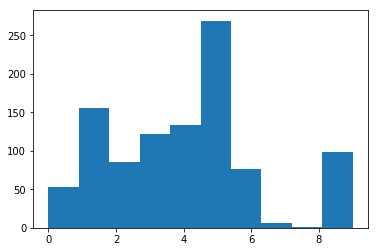

0.0016333 s


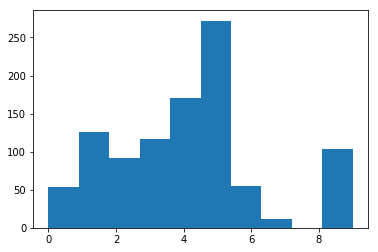

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import time

a = np.random.random(1000)
weights=np.array([[0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

wsum=weights[0].sum()
points=np.zeros(11)
for i in range (1,11):
    points[i]=points[i-1]+weights[0][i-1]/wsum

b=np.arange(1000)
start_time=time.clock()
for i in range(1000): 
    j=10
    while a[i]<points[j]:
        j-=1
    b[i]=weights[1][j]
print ("{:g} s".format(time.clock()-start_time))
_=plt.hist(b)
plt.show()
for i in range(10):
    for j in range(i, 9):
        if weights[0][j]>weights[0][j+1]:
                tmp=weights[0][j]
                weights[0][j]=weights[0][j+1]
                weights[0][j+1]=tmp
                tmp=weights[1][j]
                weights[1][j]=weights[1][j+1]
                weights[1][j+1]=tmp
for i in range (1,11):
    points[i]=points[i-1]+weights[0][i-1]/wsum
start_time=time.clock()
for i in range(1000):
    j=10
    while a[i]<points[j]:
        j-=1
    b[i]=weights[1][j]
print ("{:g} s".format(time.clock()-start_time))
_=plt.hist(b)
plt.show()

### Inverse transform method

В следующем предложении заключается идея метода *inverse transform*:

Если $\xi$ имеет равномерное распределение в $[0,1]$, тогда $F^{-1}(\xi)$ распределена по закону $F$. (Для каких $F$ это верно?)

### Задача
Смделируйте выборку размера 1000 из распределения $Exp(\lambda)$. Постройте выборочную гистограмму и точный график плотности распределения.

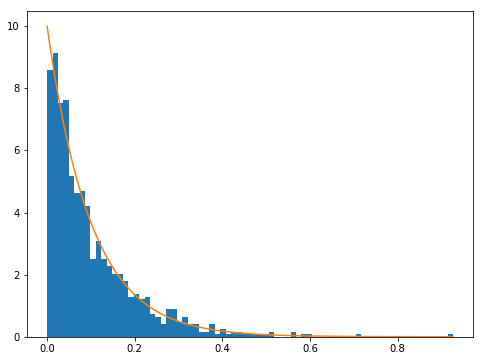

In [29]:
from math import log, exp

plt.figure(figsize=(8,6))
a=10
r=[np.random.rand() for i in range(1000)]
r.sort()
hi=[-1/a*log(1-r[i]) for i in range(1000)]
plt.hist(hi,density=True,bins=75)
pl=[a*exp(-a*hi[i]) for i in range(1000)]
plt.plot(hi,pl)
plt.show()

### Rejection sampling (Accept-reject method)

Идея метода: сэмплить из распределения, из которого умеем, а затем отбирать точки, которые следуют нужному распределению. Картинка иллюстрирует идею метода:
<img src=https://colcarroll.github.io/hamiltonian_monte_carlo_talk/images/bayes_talk.015.png style="width: 50%;"/>
 

### Задача
Обоснуйте, что метод accept-reject действительно производит выборку из нужного распределения. Смоделируйте 1000 точек из усеченного распределения Коши, приведенного ниже, используя генератор равномерного распределения. Нарисуйте график полученной выборочной гистограммы и сравните его с графиком точной функции плотности.

In [6]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
dist = stats.cauchy()
x = np.linspace(-4, 4, 100)
plt.fill_between(x, 0, dist.pdf(x)) #needs to be normalized!
plt.show()

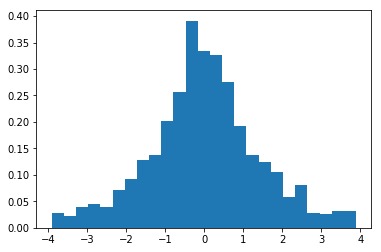

In [18]:
import numpy as np
from scipy.stats import norm
from numpy.random import uniform

a= np.zeros(1000)
i=0
while (a[999]==0):
    b=np.random.random(1)
    u=(np.random.random(1)-1/2)*8
    if b<1/(u*u+1):
            a[i]=u
            i=i+1
 
_=plt.hist(a,bins=25, density= True)
plt.show()

##  Coordinate transformation method

Метод аccept-reject в ряде случаев может оказываться неэффективным и требовать слишком много пробных точек. Альтернатива -  попробовать найти преобразование координат, которое переводит простую область (из которой легко сэмплить, например, едининчный квадрат) в требуемую, но при этом сохраняет соотношение площадей.

### Задача
Смоделировать выборку из 500 точек равномерно распределенных внутри данного треугольника без использования метода отбора. 

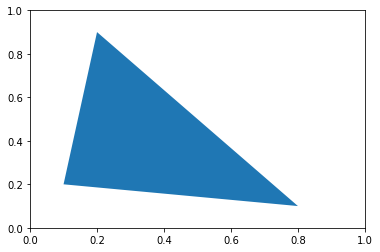

In [7]:
import matplotlib as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

polygon = Polygon(0.1 * np.array([[1, 2], [2, 9], [8, 1]]), True)
plt.gca().add_collection(PatchCollection([polygon]))

plt.show()

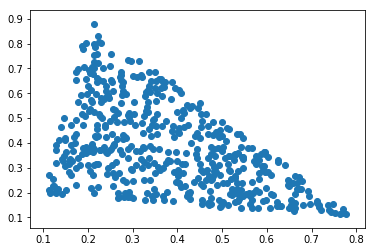

In [63]:
a= np.zeros((2, 500))
for i in range (500):
    x=np.random.random(1)
    y=np.random.random(1)
    while x+y>1:
        x=np.random.random(1)
        y=np.random.random(1)
    a[0][i]=0.1+x*0.7+y*0.1
    a[1][i]=0.2+y*0.7-x*0.1
_=plt.scatter(a[0],a[1])
plt.show()

### Задача
Смоделировать выборку из 500 точек внутри данного круга без использования метода отбора.

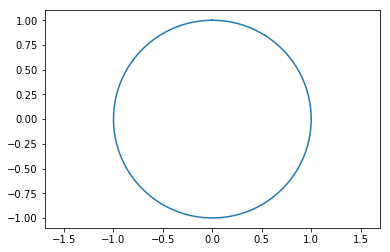

In [0]:
from matplotlib.patches import Circle
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.axis('equal')
plt.show()

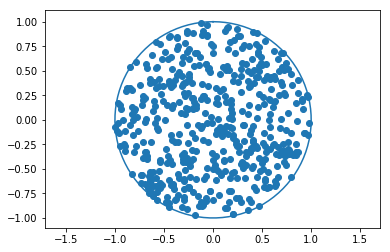

In [215]:
a= np.zeros((2, 500))
i=0;
for i in range(500):
    x=2*np.random.random(1)-1
    y=2*np.random.random(1)-1
    if np.abs(y)/np.abs(x)<1:
        l= (1+(y/x)*(y/x))**0.5
    else:
        l=(1+(x/y)*(x/y))**0.5
    a[0][i]=x/l
    a[1][i]=y/l
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.sin(t), np.cos(t))
plt.scatter(a[0],a[1])
plt.axis('equal')
plt.show()

### Задача
Напишите функцию, которая моделирует случайное симметричное блуждание на двумерной решетке длины n c началом и концом в точке (0, 0). Приведите графики выборочных траекторий для n=100.

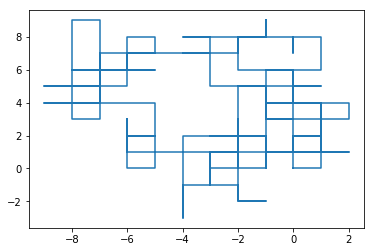

In [27]:
import matplotlib.pyplot as plt
import numpy as np
a= np.random.randint(4) 
b=np.zeros((2,2))
n=100
if a==0:
    b[0][1]=1
elif a==1:

    b[1][1]=1
elif a==2:
    b[0][1]=-1
elif a==3:
    b[1][1]=-1
c=np.zeros((2,1))
i=1
while (b[0][i]!=0)or(b[1][i]!=0)and (i<10000):
    i+=1
    c[0]=b[0][i-1]
    c[1]=b[1][i-1]
    
    a= np.random.randint(4)
    if a==0:
        c[0]+=1
    elif a==1:
        c[0]-=1
    elif a==2:
        c[1]-=1   
    elif a==3:
        c[1]+=1
    if c[1]<n and c[0]<n:
        b=np.append(b,c, axis=1)
    else:
        i-=1
plt.plot(b[0], b[1])
plt.show()

## Random normal generator

### Задача
Докажите, что приведенный ниже алгоритм (Box-Muller algorithm) формирует выборку из независимых N(0,1) случаных величин. Модифицируйте метод, чтобы исключить вызовы тригонометрических функций ```np.sin``` и ```np.cos```. С помощью модивицированного метода смоделируйте выборку объема 1000 из двумерного гауссовского распределения со средним (3, 6) и ковариационной матрицей ((2, 1), (1, 4)). Постройте 2D гистограмму полученного распределения.

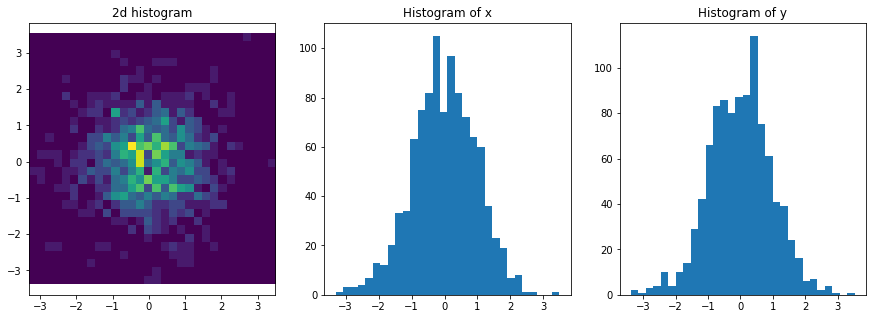

In [42]:
n = 1000
i = 0
nocos = np.array([])
nosin = np.array([])
while i<n:
    u, v = 2*np.random.rand(2,1)-1
    s = u**2+v**2
    if 0<s<=1:
        nocos = np.append(nocos, u)
        nosin = np.append(nosin, v)
        i+=1

s = nocos**2+nosin**2
r = np.sqrt(-2 * np.log(s)/s)
x = nocos * r
y = nosin * r
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x, y, bins=30)
ax[0].axis('equal')
ax[1].hist(x, bins=30)
ax[2].hist(y, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of x")
ax[2].set_title("Histogram of y")
plt.show()

Надо сделать выборку из N(0,1) и сделать замену координат, чтобы единичная матрица перешла в матрицу {{2,1},{1,4}}, и затем добавить среднее . При линейно замене с матрицей A  матрица ковариаций X, Y  переходит в  A^T*A .При помощи интернета находим нужную матрицу {{sqrt(7)/2,1/2)},{0,2}}

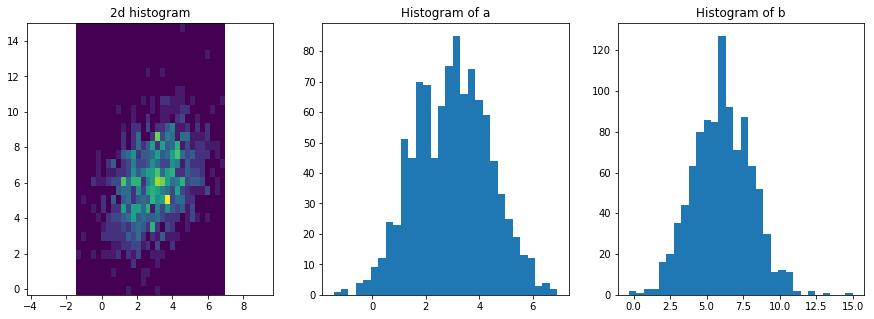

2.976588025477039 6.057378857280095
[[1.97682285 0.98688229]
 [0.98688229 3.95718469]]


In [40]:
x1 = np.sqrt(7) / 2 * x + 1 / 2 * y + 3
y1 = 2 * y + 6

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist2d(x1, y1, bins=30)
ax[0].axis('equal')
ax[1].hist(x1, bins=30)
ax[2].hist(y1, bins=30)
ax[0].set_title("2d histogram")
ax[1].set_title("Histogram of a")
ax[2].set_title("Histogram of b")
plt.show()
print(np.mean(a),np.mean(b))

print(np.cov([a,b]))

## Практическое задание

Реализовать метод генерации случайного разбиения n-элементного множества на подмножества. С его помощью оценить ожидаемое число подмножеств в случайном разбиении множества из 100 элементов. 

Подсказка 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Подсказка 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [44]:
def razb(n, size):
    arr = np.zeros(n)
    for i in range(n):
        arr[i] = (i + 1)**n / math.factorial(i)
    arr /= arr.sum()
    
    group = np.random.choice(np.arange(1, n + 1), p=arr, size=size)
    ans = np.zeros((size, n))
    for i in range(size):
        ans[i, :] = np.random.choice(np.arange(1, group[i] + 1), size=n)
    return answer
razb(100, 10000).max(axis=1).mean()